In [35]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [36]:
def intercala_listas(lista1,lista2, lista3):
    # Assumes lista1 and lista2 are the same length 
    lista = []

    for i in range(len(lista1)):
        lista.append(lista1[i])
        lista.append(lista2[i])
        lista.append(lista3[i])

    return lista

In [37]:
# # step 1

# CANT_ENTRENAMIENTO=800
# CANT_PRUEBAS=180
# filenames_train = intercala_listas(
#     [f'dataset/COVID/images/COVID-{i}.png' for i in range(1, CANT_ENTRENAMIENTO+1)],
#     [f'dataset/Normal/images/Normal-{i}.png' for i in range(1, CANT_ENTRENAMIENTO+1)],
#     [f'dataset/Viral Pneumonia/images/Viral Pneumonia-{i}.png' for i in range(1, CANT_ENTRENAMIENTO+1)])
# labels_train = tf.constant(intercala_listas(
#     [1 for i in range(1,CANT_ENTRENAMIENTO+1)],
#     [0 for i in range(1,CANT_ENTRENAMIENTO+1)],
#     [2 for i in range(1,CANT_ENTRENAMIENTO+1)]))

# filenames_test = intercala_listas(
#     [f'dataset/COVID/images/COVID-{i}.png' for i in range(CANT_ENTRENAMIENTO+1, CANT_ENTRENAMIENTO+CANT_PRUEBAS+1)],
#     [f'dataset/Normal/images/Normal-{i}.png' for i in range(CANT_ENTRENAMIENTO+1, CANT_ENTRENAMIENTO+CANT_PRUEBAS+1)],
#     [f'dataset/Viral Pneumonia/images/Viral Pneumonia-{i}.png' for i in range(CANT_ENTRENAMIENTO+1, CANT_ENTRENAMIENTO+CANT_PRUEBAS+1)])
# labels_test = tf.constant(intercala_listas(
#     [1 for i in range(1,CANT_PRUEBAS+1)],
#     [0 for i in range(1,CANT_PRUEBAS+1)],
#     [2 for i in range(1,CANT_ENTRENAMIENTO+1)]))

# print(filenames_train)
# print(labels_train)
# print(filenames_test)
# print(labels_test)

In [38]:
CANT_ENTRENAMIENTO=800
CANT_PRUEBAS=200
TOTAL = CANT_ENTRENAMIENTO+CANT_PRUEBAS
USAR_MASK = True
mask = ""
if USAR_MASK:
    mask = "_with_mask"

filenames = []
labels = []

for i in range(1,TOTAL+1):
    for type in ['COVID','Normal','Viral Pneumonia']:
        filenames.append(f'./dataset/{type}/images{mask}/{type}-{i}.png')
        labels.append(1 if type == 'COVID' else 0 if type == 'Normal' else 2)

filenames_train = filenames[0:CANT_ENTRENAMIENTO*2]
labels_train = labels[0:CANT_ENTRENAMIENTO*2]

filenames_test = filenames[CANT_ENTRENAMIENTO*2:TOTAL*2]
labels_test = labels[CANT_ENTRENAMIENTO*2:TOTAL*2]

In [39]:
# step 2: create a dataset returning slices of `filenames`
datos_train = tf.data.Dataset.from_tensor_slices((filenames_train, labels_train))
datos_test = tf.data.Dataset.from_tensor_slices((filenames_test, labels_test))

In [40]:
#Obtenemos en variables separadas los datos de entrenamiento (60k) y pruebas (10k)
datos_entrenamiento, datos_pruebas = datos_train, datos_test
datos_entrenamiento

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [41]:
nombres_clases = ['normal','covid','pneumonia']
nombres_clases


['normal', 'covid', 'pneumonia']

In [42]:
#Funcion de normalizacion para los datos (Pasar de 0-255 a 0-1)
#Hace que la red aprenda mejor y mas rapido

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_image(image_string, channels=0)
  image = tf.cast(image_decoded, tf.float32)
  image /= 255 
  return image, label

#Normalizar los datos de entrenamiento y pruebas con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(_parse_function)
datos_pruebas = datos_pruebas.map(_parse_function)

#Agregar a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

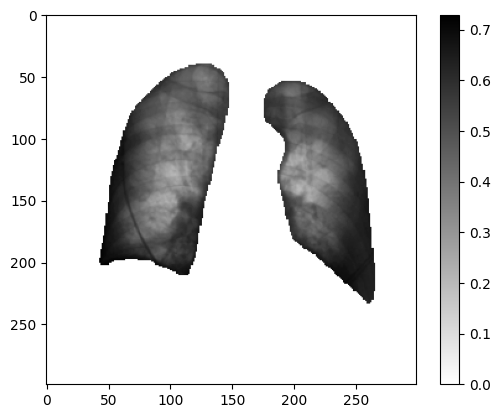

In [43]:
#Mostrar una imagen de los datos de pruebas, de momento mostremos la primera
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((299,299)) #Redimensionar, cosas de tensores, lo veremos despues# imagen = imagen.numpy().reshape((28,28)) #Redimensionar, cosas de tensores, lo veremos despues

import matplotlib.pyplot as plt

#Dibujar dibujar
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()


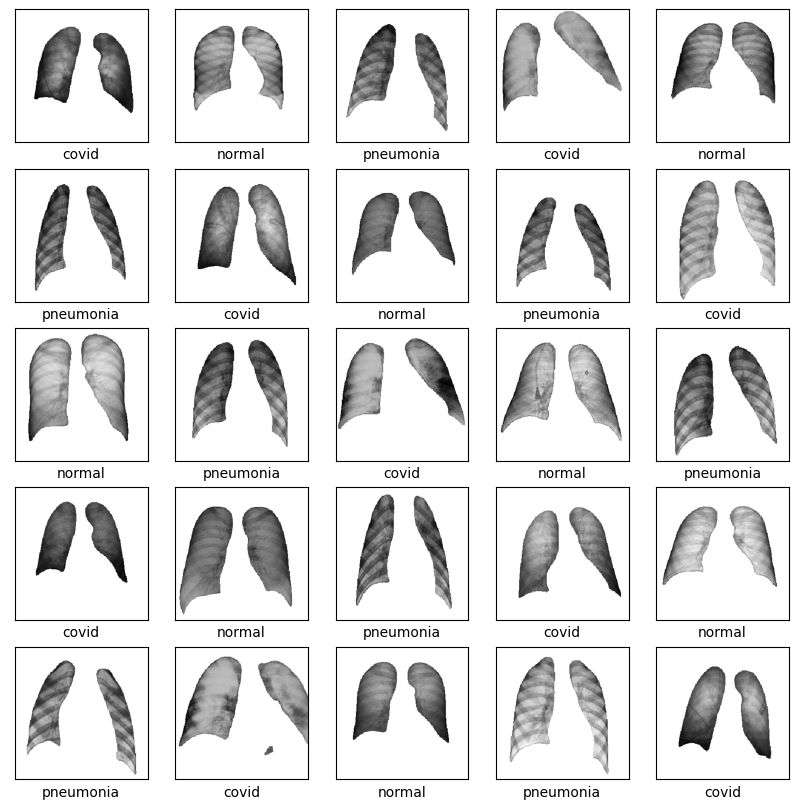

In [44]:
#Dibujar mas
plt.figure(figsize=(10,10))
# for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((299,299))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()


In [45]:
#Crear el modelo
modelo = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(299, 299, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  # tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(), #1 - blanco y negro
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  #tf.keras.layers.Dense(2, activation=tf.nn.softmax),
  tf.keras.layers.Dense(3, activation=tf.nn.softmax) #Para redes de clasificacion
])


In [46]:
# modelo = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(299, 299, 1)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(512, activation="sigmoid")
# ])

In [47]:
#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [48]:
# #Los numeros de datos en entrenamiento y pruebas (60k y 10k)
num_ej_entrenamiento = CANT_ENTRENAMIENTO
num_ej_pruebas = CANT_PRUEBAS

In [49]:
print(num_ej_entrenamiento)
print(num_ej_pruebas)

800
200


In [50]:
#El trabajo por lotes permite que entrenamientos con gran cantidad de datos se haga de manera mas eficiente
TAMANO_LOTE = 32

#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red
#no se vaya a aprender el orden de las cosas
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [51]:
import math
#Entrenar
historial = modelo.fit(datos_entrenamiento, epochs=60,batch_size=TAMANO_LOTE, steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE),validation_data = datos_pruebas,validation_batch_size=TAMANO_LOTE, validation_steps=math.ceil(num_ej_pruebas/TAMANO_LOTE))

Epoch 1/60
25/25 [==============================] - 57s 2s/step - loss: 0.8243 - accuracy: 0.6450 - val_loss: 0.5849 - val_accuracy: 0.8080
Epoch 2/60
25/25 [==============================] - 57s 2s/step - loss: 0.5363 - accuracy: 0.8037 - val_loss: 0.4067 - val_accuracy: 0.8527
Epoch 3/60
25/25 [==============================] - 58s 2s/step - loss: 0.3788 - accuracy: 0.8763 - val_loss: 0.3505 - val_accuracy: 0.8929
Epoch 4/60
25/25 [==============================] - 59s 2s/step - loss: 0.3352 - accuracy: 0.8838 - val_loss: 0.3783 - val_accuracy: 0.8705
Epoch 5/60
25/25 [==============================] - 57s 2s/step - loss: 0.3217 - accuracy: 0.8813 - val_loss: 0.2849 - val_accuracy: 0.9062
Epoch 6/60
25/25 [==============================] - 63s 3s/step - loss: 0.3527 - accuracy: 0.8625 - val_loss: 0.3302 - val_accuracy: 0.8973
Epoch 7/60
25/25 [==============================] - 66s 3s/step - loss: 0.1988 - accuracy: 0.9375 - val_loss: 0.2770 - val_accuracy: 0.9286
Epoch 8/60
25/25 [==

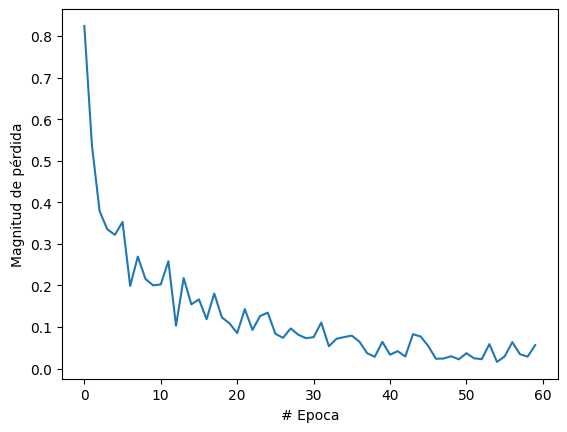

In [52]:
#Ver la funcion de perdida
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

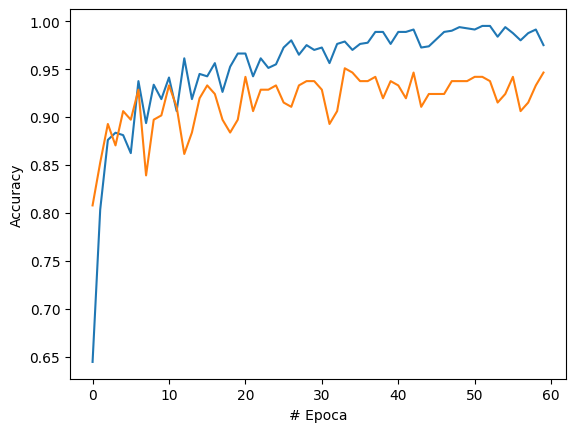

In [60]:
plt.xlabel("# Epoca")
plt.ylabel("Accuracy")
ax = plt.plot(historial.history["accuracy"])
ax = plt.plot(historial.history["val_accuracy"])

1/1 [==============================] - 1s 838ms/step


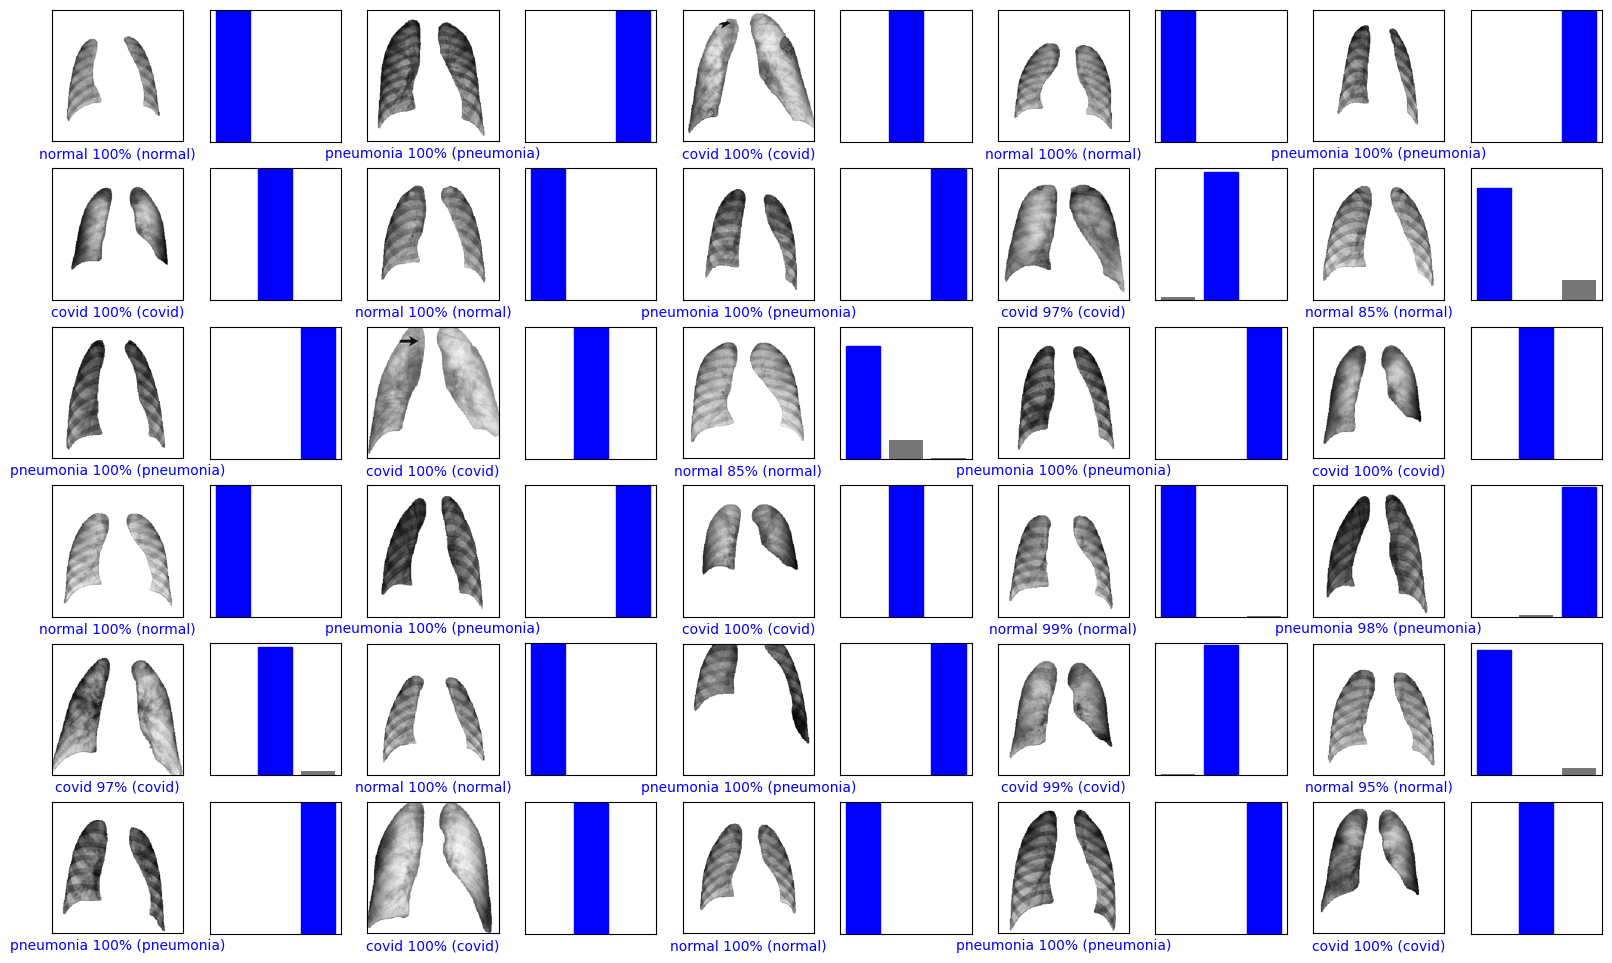

In [53]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(3), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 6
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [54]:
#Probar una imagen suelta
imagen = imagenes_prueba[4] #AL ser la variable imagenes_prueba solo tiene lo que se le puso en el bloque anterior heheh
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])

1/1 [==============================] - 0s 159ms/step
Prediccion: pneumonia


In [55]:
#Exportacion del modelo a h5
#modelo.save('modelo_exportado.h5')

In [56]:
#Instalar tensorflowjs para convertir el h5 a un modelo que pueda cargar tensorflowjs en un explorador
# %pip install tensorflowjs

In [57]:
#Convertir el archivo h5 a formato de tensorflowjs
#!mkdir tfjs_target_dir
#!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir

In [58]:
#Veamos si si creo la carpeta
#!ls

In [59]:
#Veamos el contenido de la carpeta
#!ls tfjs_target_dir